In [1]:
import numpy as np 
import pandas as pd 
import pickle
from tqdm import tqdm
import os
import cv2
from scipy.spatial import ConvexHull
import random
import glob
import imgaug as ia
from imgaug import augmenters as iaa
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import json
import io

### Defining global variables

In [2]:

BRIKKEPATH = "..\\detect-tantrix-pieces\\brikker_raw\\"
GRABCUTPATH = "grabcut\\"
FINISHEDPATH = "F:\\tantrix-data\\data1\\"


brikkeInt = 56
nb_tileSets = 2

rx = 815
w = 150
ry = 400
h = 150

imgH = 300
imgW = 300

centerX = int(imgW/2)
centerY = int(imgH/2)

thinking_time = 500
intersect_ratio = 0


#black patch taken for the center of a tile(taken from an already processed image)
#This is used to get rid of som reflection in the raw tile image
black_roi = cv2.imread(GRABCUTPATH+"0p3.png")
black_roi = black_roi[45:45+15,45:45+25]

In [65]:
def toString(*args):
    
    i = 0
    for arg in args:
        if type(arg)==list:
            for a in arg:
                if i == 0:
                    string = str(a)
                else:
                    string += ";"+str(a)
                i+=1
        elif i == 0:
            string = str(arg)
        else:
            string += ";"+str(arg)
        i += 1
    return string

### Save background images in the right format

In [3]:
data_dir="data" # Directory that will contain all kinds of data (the data we download and the data we generate)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

# Pickle file containing the background images from the DTD
backgrounds_pck_fn=data_dir+"/backgrounds.pck"

# Pickle file containing the card images
tiles_pck_fn=data_dir+"/tiles.pck"


#### Loading background images in a pickle file

#### Create background class

In [12]:
class Backgrounds():
    def __init__(self, backgrounds_pck_fn):
        self._images = pickle.load(open(backgrounds_pck_fn, 'rb'))
        self._nb_images = len(self._images)
        print("Nb of images loades: ", self._nb_images)
    def get_random(self, display = False):
        bg = self._images[random.randint(0, self._nb_images-1)]
        if display:
            plt.imshow(bg)
        return bg
    
#Initialize class
background = Backgrounds(backgrounds_pck_fn)
        

Nb of images loades:  5640


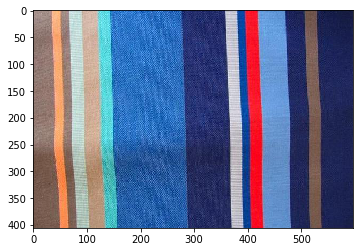

In [13]:
_=background.get_random(True)

### Creating the alphamask

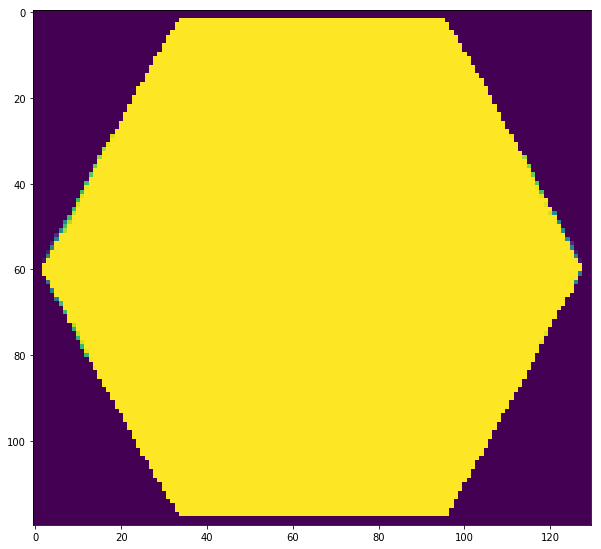

In [19]:
alphamask = cv2.cvtColor(cv2.imread("alphamask.png"), cv2.COLOR_BGR2GRAY)

marg_alphamask = 2 

h_alphamask = 120
w_alphamask = 130
plt.figure(figsize=(10,10))
plt.imshow(alphamask)

In [6]:
def extract_tile(img, output_fn, with_black_patch = True):
    src = img[ry:ry+h, rx:rx+w]
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    ret, threshmask = cv2.threshold(gray,100,255,0)
    inv_threshmask = cv2.bitwise_not(threshmask)

    _, contours, _ =cv2.findContours(inv_threshmask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    cv2.drawContours(gray, contours, -1, (255,255,255), -1)
    xb,yb,wb,hb = cv2.boundingRect(contours[0])

    gray = gray[yb:yb+h_alphamask,xb:xb+w_alphamask]
    src = src[yb:yb+h_alphamask,xb:xb+w_alphamask]

    alphachannel=np.zeros(src.shape[:2],dtype=np.uint8)

    _,contmask = cv2.threshold(gray,250,255,0)
    inv_contmask = cv2.bitwise_not(contmask)



    j = 0
    for pts in contours[0]:
        if j < 23: #Special case to take care of some variation in  half the images
            pts[0][0] -= (xb-marg_alphamask) 
            pts[0][1] -= (yb-marg_alphamask)
        else:
            pts[0][0] -= (xb+marg_alphamask-1) 
            pts[0][1] -= (yb+marg_alphamask-1)

        j +=1

    cv2.drawContours(alphachannel, contours, -1, 255, -1)


    alphachannel = cv2.bitwise_and(alphachannel, alphamask)

    if with_black_patch:
        src[0:15,22:47] = black_roi #cover the light reflection in the upper left corner
    
    
    src=cv2.cvtColor(src,cv2.COLOR_BGR2BGRA)

    src[:,:,3]= alphachannel
    
    if output_fn is not None:
        cv2.imwrite(output_fn, src)
        
    return src

In [9]:
def extract_tiles_from_folder_images(input_folder_name, nb_img, output_folder_name):
    nb_img_processed = 0
    
    for i in range(nb_img):
        nr = i+1
        filnavn = input_folder_name+"("+str(nr)+").jpg"
        src = cv2.imread(filnavn)
        try:
            if src == None:
                print("Could not find image "+filnavn)
                continue
        except:
            for black_patch in range(2):
                output_fn = output_folder_name +str(black_patch)+"p"+str(nr)+".png"
                extract_tile(src, output_fn, black_patch)
                nb_img_processed += 1
            
    print("Processed # of images: ", nb_img_processed)
    return nb_img_processed

In [12]:
extract_tiles_from_folder_images(BRIKKEPATH, brikkeInt, GRABCUTPATH)

Processed # of images:  112


112

## Creating df for path and kpts

### Inserting keypoints


In [12]:
def save_tiles_together_with_keypoints(label_fn, tile_sets):
    tiles = {}
    labels = pd.read_csv(label_fn,';')
    for i in range(tile_sets):
        for index, row in labels.iterrows():
            tileNr = row['tileNr']
            if tileNr not in tiles:
                tiles[tileNr] = []
                
            img=cv2.cvtColor(cv2.imread(GRABCUTPATH+str(i)+"p"+str(tileNr)+".png" ,cv2.IMREAD_UNCHANGED),cv2.COLOR_BGRA2RGBA)
            thinglist = [img, row[1:]]
            tiles[tileNr].append(thinglist)
    
    pickle.dump(tiles, open(tiles_pck_fn, 'wb'))


In [13]:
save_tiles_together_with_keypoints('keyptsxy.csv', nb_tileSets)


In [4]:
class Tiles():
    def __init__(self, tiles_pck_fn=tiles_pck_fn):
        self._tiles = pickle.load(open(tiles_pck_fn, 'rb'))
    
    def get_random(self, tileNr=None, display=False):
        if tileNr is None:
            tileNr = random.choice(list(self._tiles.keys()))
        tileInfo = self._tiles[tileNr][random.randint(0, nb_tileSets-1)] #self._nb_tiles_by_tileNr[tileNr]
        kpts = tileInfo[1]
        
        if display:
            plt.imshow(tileInfo[0])
        return tileInfo[0], kpts 
tiles = Tiles()

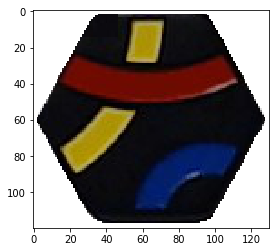

In [17]:
tile, kpts = tiles.get_random(display=True)

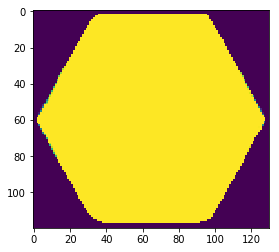

In [18]:
plt.imshow(tile[:,:,3])


In [19]:
kpts

jsx     65
jsy      8
jex     20
jey     85
bsx    110
bsy     85
bex     66
bey    110
rsx    110
rsy     30
rex     17
rey     35
gsx      0
gsy      0
gex      0
gey      0
Name: 6, dtype: int64

## Transformations


In [5]:

#2 tile
transform_1tile = iaa.Sequential([
    iaa.Affine(scale=[0.65,1.1]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.90,0.50),"y":(-0.90,0.50)}),
])

#3 tile
trans_rot1 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (10, 20)}),
    iaa.Affine(rotate=(22,30))
])
trans_rot2 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (0, 5)}),
    iaa.Affine(rotate=(10,15))
])

# imgaug transformation for the background
scaleBg=iaa.Scale({"height": imgH, "width": imgW})

In [21]:
def is_same(list1,list2):
    for i in range(len(list1)):
        if not(list1[i]==list2[i]):
            return False
    return True

In [6]:
def kpts_to_iakpts_list(kpts):
    iakpts_list = []
    for i in range(int(len(kpts)/2)):
        ix=kpts[2*i]
        iy=kpts[2*i+1]
        if not(ix+iy):
            ix = 65
            iy = 60
        iakpts_list.append(ia.Keypoint(x=centerX+ix, y=centerY+iy))
    return ia.KeypointsOnImage(iakpts_list, shape=(imgH, imgW, 3))

def iakpts_to_polygon_rotated(iakpts):
    """
        Convert imgaug keypoints to shapely polygon
    """
    scale_rot = iaa.Sequential([
    iaa.Affine(scale=(1.33)),
    iaa.Affine(rotate=(30))
    ])
    
    kpts_aug = [scale_rot.augment_keypoints([iakpts][0][0])]
    pts = np.zeros((len(kpts_aug[0][0].keypoints),2)) 
    i=0
    for kp in kpts_aug[0][0].keypoints:
        pts[i]=[kp.x,kp.y] 
        i +=1
    CHpts = []
    hull = ConvexHull(pts)
    for j in hull.vertices:
        CHpts.append(pts[j])
    poly = Polygon(CHpts)
    return poly

def iakpts_to_bb(kpts):
    extend=3 # To make the bounding box a little bit bigger
    
    kpsx=[kp.x for kp in kpts.keypoints]
    minx=max(0,int(min(kpsx)-extend))
    maxx=min(imgW,int(max(kpsx)+extend))
    
    kpsy=[kp.y for kp in kpts.keypoints]
    miny=max(0,int(min(kpsy)-extend))
    maxy=min(imgH,int(max(kpsy)+extend))
    
    if minx==maxx or miny==maxy:
        return None
    else:
        return ia.BoundingBox(x1=minx,y1=miny,x2=maxx,y2=maxy)
    

    
def bbs_are_within(list_bb, minx=0, miny=0, maxx=imgW, maxy=imgH):
    for bb in list_bb:
        if bb is None or int(round(bb.x2)) >= maxx or int(round(bb.y2)) >= maxy or int(bb.x1)<=minx or int(bb.y1)<=miny:
            return False
    return True
        
    
        
def augmentImg(img, iakpts_list, seq, restart = True):
    invalid = True

    while invalid:
        if restart:
            myseq = seq.to_deterministic()
        else:
            myseq = seq
        
        img_aug = myseq.augment_images([img])[0]
        list_iakpts_aug = [myseq.augment_keypoints([iakpts_list])]
        list_bb = [iakpts_to_bb(list_iakpts_aug[0][0])]
        '''
        print("Before aug")
        for kasd in iakpts_list.keypoints:
            print([kasd.x,kasd.y])
        print("after aug")
        for kasd in list_iakpts_aug[0][0].keypoints:
            print([kasd.x,kasd.y])
        '''
        if bbs_are_within(list_bb):
            invalid = False
        elif not restart:
            #The whole cluster of tiles has to be restarted
            return None, list_iakpts_aug
            
            
    return img_aug, list_iakpts_aug
        
        
def is_iakpts_intersecting(iakpts1, iakpts2, intersect_ratio=0):
    poly1 = iakpts_to_polygon_rotated(iakpts1)
    
    poly2 = iakpts_to_polygon_rotated(iakpts2)
    p2a = poly2.area
    intersect = poly1.intersection(poly2)
    areal_ratio = (p2a-intersect.area)/p2a
    polys = [poly1, poly2]
    if areal < 1-intersect_ratio:
        return True
    else:
        return False
    
    
    
    
        
        

In [23]:
def toJSON(img, keypoints):
    return {"img": img, "kps":keypoints }

In [14]:
class Scene:
    def __init__(self, bgImg, img1, kpts1, img2=None, kpts2=None, img3=None, kpts3=None):
        
        if img3 is not None:
            self.create3TileScene(bgImg, img1, kpts1, img2, kpts2, img3, kpts3)
        else:
            self.create1TileScene(bgImg, img1, kpts1)#
        
            
    def create1TileScene(self, bgImg, img1, kpts1):
        iakpts1 = kpts_to_iakpts_list(kpts1)
        
        #Random augment tile
        self.pimg1 = np.zeros((imgH, imgW, 4), dtype=np.uint8)
        self.pimg1[centerY:centerY+h_alphamask, centerX:centerX+w_alphamask] = img1
        self.pimg1_aug, self.iakpts1_aug = augmentImg(self.pimg1, iakpts1, transform_1tile)
        
        #Scale background to standard size
        self.bg = scaleBg.augment_image(bgImg)
        mask1 = np.stack([self.pimg1_aug[:,:,3]]*3,-1)
        self.final = np.where(mask1, self.pimg1_aug[:,:,0:3], self.bg)
        
        self.finalstring = np.array2string(self.final)
        self.x_str = np.array_repr(self.final).replace('\n', '')
    
    def create2TileScene(self, bgImg, img1, kpts1, img2, kpts2):
        iakpts1 = kpts_to_iakpts_list(kpts1)
        iakpts2 = kpts_to_iakpts_list(kpts2)
        
        
        #Random augment tile1
        self.pimg1 = np.zeros((imgH, imgW, 4), dtype=np.uint8)
        self.pimg1[centerY:centerY+h_alphamask, centerX:centerX+w_alphamask] = img1
        self.pimg1_aug, iakpts1_aug = augmentImg(self.pimg1, iakpts1, transform_1tile)
        
        
        
        
        
        intersecting = True
        time = 0
        while intersecting and time < thinking_time:
            time += 1
            self.pimg2 = np.zeros((imgH, imgW, 4), dtype=np.uint8)
            self.pimg2[centerY:centerY+h_alphamask, centerX:centerX+w_alphamask] = img2
            self.pimg2_aug, iakpts2_aug = augmentImg(self.pimg2, iakpts2, transform_1tile)
            bitwisealphamask12 = np.array(cv2.bitwise_and(self.pimg1_aug[:,:,3], self.pimg2_aug[:,:,3]))
            if not bitwisealphamask12.any(): #not(is_iakpts_intersecting(iakpts1_aug,iakpts2_aug, intersect_ratio)):
                intersecting = False
        self.iakptses_aug = [iakpts1_aug, iakpts2_aug]
        
        #Scale background to standard size
        self.bg = scaleBg.augment_image(bgImg)
        mask1 = np.stack([self.pimg1_aug[:,:,3]]*3,-1)
        self.final = np.where(mask1, self.pimg1_aug[:,:,0:3], self.bg)
        mask2 = np.stack([self.pimg2_aug[:,:,3]]*3,-1)
        self.final = np.where(mask2, self.pimg2_aug[:,:,0:3], self.final)
        
        #self.finalstring = np.array2string(self.final)
        #self.x_str = np.array_repr(self.final).replace('\n', '')
        
        
    def get_kps(self):
        return  self.iakpts1_aug
        
    def write(self,ID, file_dir):
        file_name_of_img = file_dir+str(ID)+".jpg"
        plt.imsave(file_name_of_img,self.final)
        return file_name_of_img
        
    
    def display(self, withKP=False):
        fig,ax=plt.subplots(1,figsize=(8,8))
        if withKP:
            for ikpts in self.iakptses_aug:
                for kp in ikpts[0][0].keypoints:
                    ax.plot(kp.x, kp.y, color='red', marker='o')
        ax.imshow(self.final)
        #print(self.info)
        
        
    def create3TileScene(self, bgImg, img1, kpts1, img2, kpts2, img3, kpts3):
        return None



In [12]:
img1, kpts1 = tiles.get_random(tileNr=3)
img2, kpts2 = tiles.get_random()
bgImg = background.get_random()
sdt = Scene(bgImg, img1, kpts1)
sdt.display()
hei = sdt.get_kps()[0][0]
hei.get_coords_array()
plt.imshow(hei.draw_on_image(sdt.final))

hei.get_coords_array().flatten().tolist()


NameError: name 'transform_1tile' is not defined

In [83]:
def iakpts_to_csvpts(iakpts):
    csv_string = ""
    for [kpx, kpy] in iakpts[0][0].get_coords_array():
        csv_string += str(kpx)+";"+str(kpy)+";"
    return csv_string[:-1]+"\n"
    

In [15]:
col_names = ["path_to_img",
             "kp1x","kp1y",
             "kp2x","kp2y",
             "kp3x","kp3y",
             "kp4x","kp4y",
             "kp5x","kp5y",
             "kp6x","kp6y",
             "kp7x","kp7y",
             "kp8x","kp8y"]

""


In [17]:
nb_cards_to_generate = 5000

In [20]:

listOfSeries = []
for i in range(nb_cards_to_generate):
    img1, kpts1 = tiles.get_random()
    bgImg = background.get_random()
    ID = str(i)
    sd = Scene(bgImg, img1, kpts1)
    #sd.display(True)
    name_of_file = sd.write(ID, FINISHEDPATH)
    iaktps = sd.get_kps()[0][0]
    listOfSeries.append(pd.Series([name_of_file] + iaktps.get_coords_array().flatten().tolist()))
    print(i, end='\r', flush=True)
path_n_ktps = pd.DataFrame().append(listOfSeries, ignore_index=True)
    #path_n_ktps.append([name_of_file] + iaktps.get_coords_array().flatten().tolist())
path_n_ktps.columns = col_names
path_n_ktps.to_csv(FINISHEDPATH+"path_and_kpts1.csv")

In [17]:
FINISHEDPATH

'F:\\tantrix-data\\data1\\'

In [18]:
path_n_ktps.head()

,path_to_img,kp1x,kp1y,kp2x,kp2y,kp3x,kp3y,kp4x,kp4y,kp5x,kp5y,kp6x,kp6y,kp7x,kp7y,kp8x,kp8y
0,F:\tantrix-data\data1\0.jpg,76.813080,165.460083,104.443199,84.656631,159.759979,148.697449,150.255005,97.313248,113.073540,132.733383,113.073540,132.733383,126.192963,182.345154,67.875725,118.281143
1,F:\tantrix-data\data1\1.jpg,104.595367,262.261597,88.806976,184.901093,146.571045,251.568115,163.091187,206.899826,117.458710,217.295593,117.458710,217.295593,73.803467,226.011795,133.121307,175.625031
2,F:\tantrix-data\data1\2.jpg,90.036194,89.227875,90.036194,89.227875,109.086075,129.588806,45.703384,84.079544,116.330414,52.606766,68.873535,47.349976,136.897278,90.854935,65.457504,124.946136
3,F:\tantrix-data\data1\3.jpg,129.174194,264.158722,178.982864,235.642853,128.763962,209.968567,128.763962,209.968567,82.105309,241.587112,127.327400,157.870529,81.671417,184.270599,175.462067,183.560593
4,F:\tantrix-data\data1\4.jpg,240.196960,199.717758,230.398514,144.368942,190.112015,182.159958,190.112015,182.159958,141.615768,166.240616,181.226959,130.375961,203.812927,235.632187,150.838470,217.061432


In [19]:
path_n_ktps.to_csv(FINISHEDPATH+"path_and_kpts.csv")